<a href="https://colab.research.google.com/github/ImagingDataCommons/IDC-Tutorials/blob/49-fix-labs/notebooks/MICCAI23_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MHub Universal Notebook

This notebook demonstrates how to run models from [MHub.ai](https://mhub.ai) using [Imaging Data Commons (IDC)](https://portal.imaging.datacommons.cancer.gov/) data.

MHub is a novel platform, providing standardized medical imaging models with a harmonized I/O interface. MHub models are originally containerized to provide platform agnostic models that can be run locally or in the cloud without additional environmental setup. However, as it is not possible to run Docker images from within a Colab notebook, we instead setup the environment in the notebook based on the instructions outlined in the Dockerfile.


## Disclaimer

The code and data of this repository are provided to promote reproducible research. They are not intended for clinical care or commercial use.

The software is provided "as is", without warranty of any kind, express or implied, including but not limited to the warranties of merchantability, fitness for a particular purpose and noninfringement. In no event shall the authors or copyright holders be liable for any claim, damages or other liability, whether in an action of contract, tort or otherwise, arising from, out of or in connection with the software or the use or other dealings in the software.

# Global Variables


Together with the project id, we also set the default MHub model the notebook will be running if the user doesn't want to interact with the model selection dropdown.

In [18]:

MHUB_MODEL_NAME = "lungmask"       # @param {type:"string"}

## Notebook Setup

Let's start by installing all the dependencies needed for this project.

We install `ipywidgets` and `itkwidgets` to display interactive controls and visualize medical images in the notebook.

Then we install [`idc-index`](https://github.com/ImagingDataCommons/idc-index), a package for simplified access to IDC data.

As mentioned earlier, all MHub models are usually run in a Docker container, and following convention, the `/app` directory is used as the working directory. We'll clean up the `/content` folder (we don't need any of the files created with each new Colab instance) and set a symlink to the `/app` folder for your convenience. We recommend you open the *file browser* on the left to see what files are created during the course of this notebook.

*If you want to open the `/content` folder, click the following link: /content/../content*

In [19]:
%%capture

# install ipywidgets
!pip install --upgrade google-colab
!pip install ipywidgets
!pip install itkwidgets[all]==1.0a32

# install idc-index
!pip install 'idc-index>=0.2.10'

# delete content folder, create app folder and symlink /content -> /app
!rm -r /content/*
!ln -s /app /content

Import all Python libraries used throughout this notebook.

In [20]:
import subprocess
import os
import time
import json

import ipywidgets as widgets

from idc_index import index
idc_client = index.IDCClient()

from urllib.request import urlopen

# Helper Functions

The following two cells contain helper functions we will use throughout the notebook. For instance, the functions we use to convert the MHub base and model specific Dockerfiles into a `setup.sh` script to setup the environment, and utility functions to download sample patients from the Imaging Data Commons platform.

In [21]:
def docker2bash(dockerfile_path, bashscript_path):
  """
  Extract commands from a Dockerfile and convert them into a bash script.

  Arguments:
    dockerfile_path : required - path to the Dockerfile to be converted.
    bashscript_path : required - path to the bash script were the extracted
                                 commands will be appended to.
  """

  # read Dockerfile into array
  with open(dockerfile_path, 'r') as f:
    dockerfile = f.read().split('\n')

  # iterate dockerfiles line by line and generate export commands
  run = []
  inrun = False
  for line in dockerfile:
    if line.startswith('WORKDIR'):
      run.append("cd " + line.lstrip("WORKDIR"))
    elif line.startswith('ENV'):
      run.append("export " + line.lstrip("ENV"))
    elif line.startswith('RUN'):
      run.append(line.strip().lstrip('RUN').rstrip('\\').strip())
      inrun = line.strip().endswith('\\')
    elif inrun:
      run[len(run)-1] += " " + line.strip().rstrip('\\').strip()
      inrun = line.strip().endswith('\\')

  # write extracted commands to bash script
  with open(bashscript_path, 'a') as fp:
    fp.write('\n'.join(run) + '\n')


In [22]:
def patch_setup_bash(bashscript_path = '/content/setup.sh'):
  new_lines = []

  # patch bash script (#plastimatch ubuntu22 issue)
  with open(bashscript_path, 'r') as fp:
    lines = fp.readlines()

  for line in lines:
    #print(line.strip())
    if line.strip() == 'apt update && apt install -y --no-install-recommends libopenslide-dev libvips-dev plastimatch dcm2niix ffmpeg libsm6 libxext6 && rm -rf /var/lib/apt/lists/*':
      new_lines.append('apt update && apt install -y --no-install-recommends libopenslide-dev libvips-dev dcm2niix ffmpeg libsm6 libxext6 && rm -rf /var/lib/apt/lists/*')
      new_lines.append("pip3 install pyplastimatch && python3 -c 'from pyplastimatch.utils.install import install_precompiled_binaries; install_precompiled_binaries()'")
    elif len(line.strip()):
      new_lines.append(line.strip())

  with open(bashscript_path, 'w') as fp:
    fp.write('\n'.join(new_lines) + '\n')

In [23]:
def setup_environment(
    dockerfiles_paths,
    bashscript_path = '/content/setup.sh',
    env_path = '/content/env_vars.txt'
  ):

  # make sure we start with an empty setup.sh script
  if os.path.isfile(bashscript_path):
    os.remove(bashscript_path)

  # generate bash script from dockerfiles
  for dockerfile_path in dockerfiles_paths:
    docker2bash(dockerfile_path, bashscript_path)

  # patch setup bash script
  patch_setup_bash(bashscript_path)

  # append environment export
  with open(bashscript_path, 'a') as fp:
    fp.write('\n' + 'env > ' + env_path + '\n')

  # run setup script
  !chmod +x $bashscript_path
  !$bashscript_path

  # load environment variables from the file
  with open(env_path, 'r') as f:
      for line in f:
          key, value = line.strip().split('=', 1)
          os.environ[key] = value

In [24]:
def get_idc_viewer_url(studyUID, seriesUID=None):
  url = "https://viewer.imaging.datacommons.cancer.gov/viewer/"+studyUID
  if seriesUID is not None:
    url = url+"?seriesInstanceUID="+seriesUID
  return url

# Select the MHub Model

MHub hosts several pre-trained models for the analysis of CT scans, all of which are harmonized and share a common interface - so you can swap models by simply swapping model names in the run command!

You can learn more about all the models (including the data they have been trained and evaluated on) by visiting the https://mhub.ai/models page.

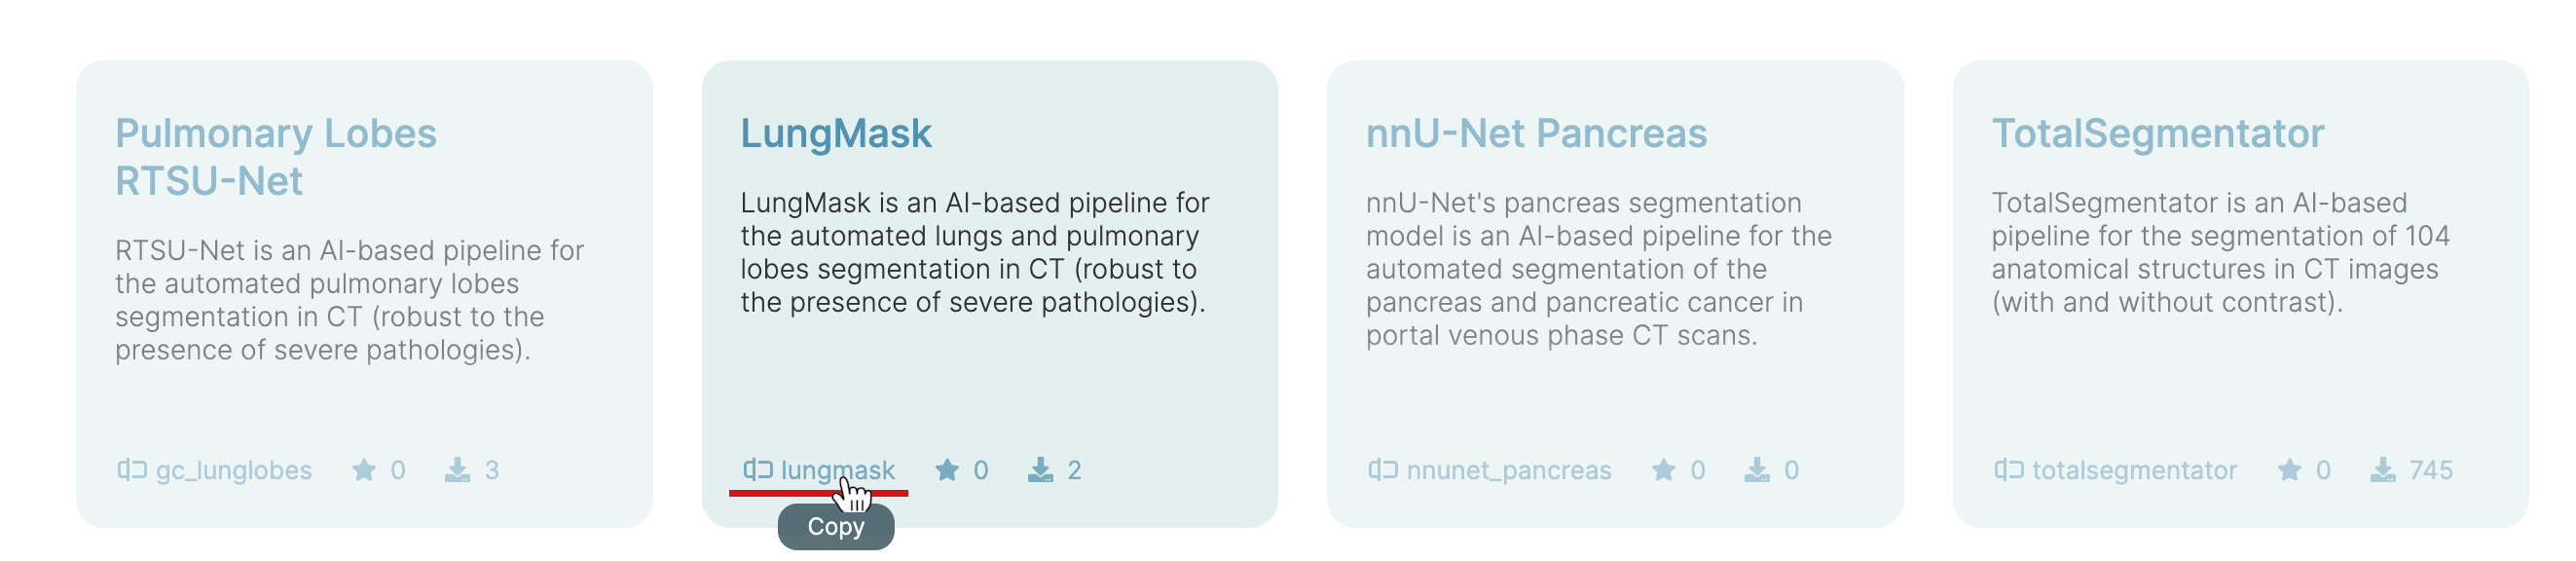

---

<br>

We can fetch a list of all available MHub models through the MHub.ai API.

Running the following two cells will spawn a dropdown box where you can select the model you would like to run in the notebook.

In [25]:
# fetch the mhub.ai api
MHUBAI_MODELS_ENDPOINT = "https://mhub.ai/api/v2/models"

# fetch information on the models on the platform
models = json.loads(urlopen(MHUBAI_MODELS_ENDPOINT).read())['data']['models']

# generate model picker
model_picker = widgets.Dropdown(options=models, value=MHUB_MODEL_NAME)

In [26]:
# display model picker
display(model_picker)

Dropdown(index=1, options=('gc_lunglobes', 'lungmask', 'nnunet_pancreas', 'totalsegmentator', 'platipy', 'casu…

In [27]:
# print choice
print("Selected Model: ", model_picker.value)

Selected Model:  lungmask


# Model Environment Setup

The next series of cell will take care of the model environment set-up. This process is essentially automated, and closely mimicks what happens inside an MHub container. We start by cloning the model folder from the MHub [Models Repository](https://github.com/MHubAI/models), based on the model selection made earlier.

We then extract the base Dockerfile and the Dockerfile of the model and pass both to our helper function `setup_environment`, which reads the Dockerfiles and sets up the environment accordingly.

**NOTE**: This step can take up to several minutes since setting up the environment involves downloading model weights with large file sizes.

In [28]:
%%capture

# clone the model repository
!git init && git sparse-checkout set "base" "models/{model_picker.value}" \
  && git fetch https://github.com/MHubAI/models.git main \
  && git merge FETCH_HEAD \
  && rm -rf .git

In [29]:
# setup the environment from Dockerfiles
setup_environment([
    f'/content/base/dockerfiles/Dockerfile',
    f'/content/models/{model_picker.value}/dockerfiles/Dockerfile'
])

mkdir: cannot create directory ‘/app’: File exists
mkdir: cannot create directory ‘/app/data’: File exists
mkdir: cannot create directory ‘/app/data/input_data’: File exists
mkdir: cannot create directory ‘/app/data/output_data’: File exists
Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 http://security.ubuntu.com/ubuntu jammy-security InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
23 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gcc is already the newest version (4:11.2.0-1ubuntu1).
jq is already the newest version (1.6-2.1ubuntu3).
wget is already the newest version (1.21.2-2ubuntu1).
curl is already the newest version (7.81.0-1ubuntu1.15).
git is already the newest ver

# Query Data from IDC

Now that the model environment is set up, it's time to download a sample input that is applicable to this model.

In the cell below, we use a fixed value for the `SeriesInstanceUID` of a DICOM CT series available in IDC, which is suitable for the `lungmask` model. But this is just a starting point for you, since you can use [IDC Portal](https://portal.imagingdatacommons.cancer.gov/explore) to find other samples and evaluate robustness of this model.


In [30]:
series_instance_uid = "1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046"
series_download_path = "/content/input_data"
!mkdir -p $download_dir
idc_client.download_dicom_series(series_instance_uid, series_download_path)

mkdir: missing operand
Try 'mkdir --help' for more information.


We can use the IDC Radiology Image Viewer to visualize the series and study of interest.

In [32]:
query = """
SELECT
  DISTINCT(StudyInstanceUID)
FROM
  index
WHERE
  SeriesInstanceUID = '{}'
""".format(series_instance_uid)

study_instance_uid = idc_client.sql_query(query)['StudyInstanceUID'][0]

print("URL to view the entire study:")
print(get_idc_viewer_url(series_instance_uid))
print()
print("URL to view the specific series:")
print(get_idc_viewer_url(study_instance_uid, series_instance_uid))

URL to view the entire study:
https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046

URL to view the specific series:
https://viewer.imaging.datacommons.cancer.gov/viewer/1.3.6.1.4.1.32722.99.99.239341353911714368772597187099978969331?seriesInstanceUID=1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046


---

<br>

Every MHub model expect the input data to be in a specific location under `/app/data/input_data`. Similarly, data generated by every MHub model is stored under `/app/data/output_data`.

When you use Docker to run an MHub model, you will typically map local folders to these locations. For the scope of this notebook, we can either move, copy, or link the data to the input location.

The next cell copies our test patient data that we just downloaded to the `input_data` folder under `/app/data`.

In [33]:
# copy databinto input folder
!cp -r $series_download_path app/data/input_data/

# Run the MHub Model

The only thing that is left to do is to run the MHub model

MHub provides a simple and standard interface: `python3 -m mhubio.run`. With the `python3 -m` option, we can start a Python module `mhubio.run` that takes care of running the MHub workflow. Each MHub model has a default workflow that processes DICOM data and generates DICOM compatible data (e.g. DICOMSEG for segmentation models).

We will show you later how to create your own custom workflows by writing a custom configuration. Different workflows can be specified using the `--workflow` argument. To run the `default` workflow, the user can simply use `--workflow default`.

Once the workflow is finished, we can move the generated output data from the output folder `/app/data/output_data` into our content folder at `/content/data/processed`.



In [34]:
!python3 -m mhubio.run --workflow default --debug

 Config:
execute:
- DicomImporter
- NiftiConverter
- LungMaskRunner
- DsegConverter
- DataOrganizer
general:
  data_base_dir: /app/data
  description: Default configuration for LungMask (dicom in, dicom out)
  version: 1.0
modules:
  DataOrganizer:
    targets:
    - dicomseg:mod=seg-->[i:sid]/lungmask.seg.dcm
  DicomImporter:
    import_dir: sorted_data
    meta:
      mod: ct
    sort_data: true
    source_dir: input_data
  DsegConverter:
    body_part_examined: CHEST
    model_name: LungMask
    skip_empty_slices: true
    source_segs: nifti:mod=seg:roi=*
  LungMaskRunner:
    batchsize: 64


 DicomImporter:

. Instance  [/app/data/_global]
├── id: global
├── sid: global
├── LOG [/app/data/_global/mhub_log/DicomImporter.log] ✓
│   └── module: DicomImporter
. Instance  [/app/data/sorted_data/1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046]
├── id: 36d03d66-cb17-4718-998e-4b8328bddcea
├── sid: 1.3.6.1.4.1.32722.99.99.298991776521342375010861296712563382046
├── DICOM [/

In [35]:
# copy output
output_dir = "/content/data/processed"
!mkdir -p $output_dir
!cp -r /app/data/output_data/$series_instance_uid $output_dir

# Inspect the Results

Finally, we can interact with the data we generated in different ways.

We can visualise the raw AI-generated segmentation masks directly in the notebook by using the utilities developed as part of the `itkwidgets` library.

In [36]:
import itk
import SimpleITK as sitk

from itkwidgets import view

AttributeError: module 'numpy.linalg._umath_linalg' has no attribute '_ilp64'

In [ ]:
dicomseg_file = os.path.join('/content/data/processed/', f'{model_picker.value}.seg.dcm')
assert os.path.isfile(dicomseg_file), f"{dicomseg_file} not found."

In [ ]:
nrrd_path = "data/processed_nrrd"

%mkdir -p $nrrd_path

!segimage2itkimage --inputDICOM $dicomseg_file \
  --outputType nrrd \
  --prefix segment \
  --outputDirectory $nrrd_path

In [ ]:
merged_mask = None

# Iterate over all the .nrrd files (segments) exported by DCMQI
for filename in os.listdir(nrrd_path):
    if filename.endswith(".nrrd"):
        file_path = os.path.join(nrrd_path, filename)
        mask = sitk.ReadImage(file_path)

        if merged_mask is None:
            merged_mask = mask
        else:
            merged_mask = merged_mask + mask

# Save the merged mask
path_to_merged_mask = os.path.join(nrrd_path, "merged_mask.nrrd")
sitk.WriteImage(merged_mask, path_to_merged_mask)

In [ ]:
merged_mask = itk.imread(path_to_merged_mask)
viewer = view(label_image=merged_mask)

viewer.set_image_gradient_opacity(0.4)
viewer.set_label_image_blend(0.8)
viewer.set_background_color([0.25,0.25,0.25])
viewer.set_label_image_weights([0, 1])

We can also visualize the CT scan together with the segmentation labels.

Note: this could take a little bit longer to render!

In [ ]:
image = itk.imread(series_download_path)

viewer = view(image, label_image=merged_mask)

viewer.set_background_color([0.0,0.0,0.0])

---
For further analysis, we can download the DICOM Series used for segmentation and the results of the MHub segmentation model we selected.

These data can be then inspected locally with a viewer of our choice (e.g., 3DSlicer).

In [ ]:
%%capture

archive_fn = "%s-%s.zip"%(my_SeriesInstanceUID, model_picker.value)

try:
  os.remove(archive_fn)
except OSError:
  pass

!zip -j -r $archive_fn $dicomseg_file $series_download_path

In [ ]:
filesize = os.stat(archive_fn).st_size/1024e03
print('Starting the download of "%s" (%2.1f MB)...\n'%(archive_fn, filesize))

files.download(archive_fn)

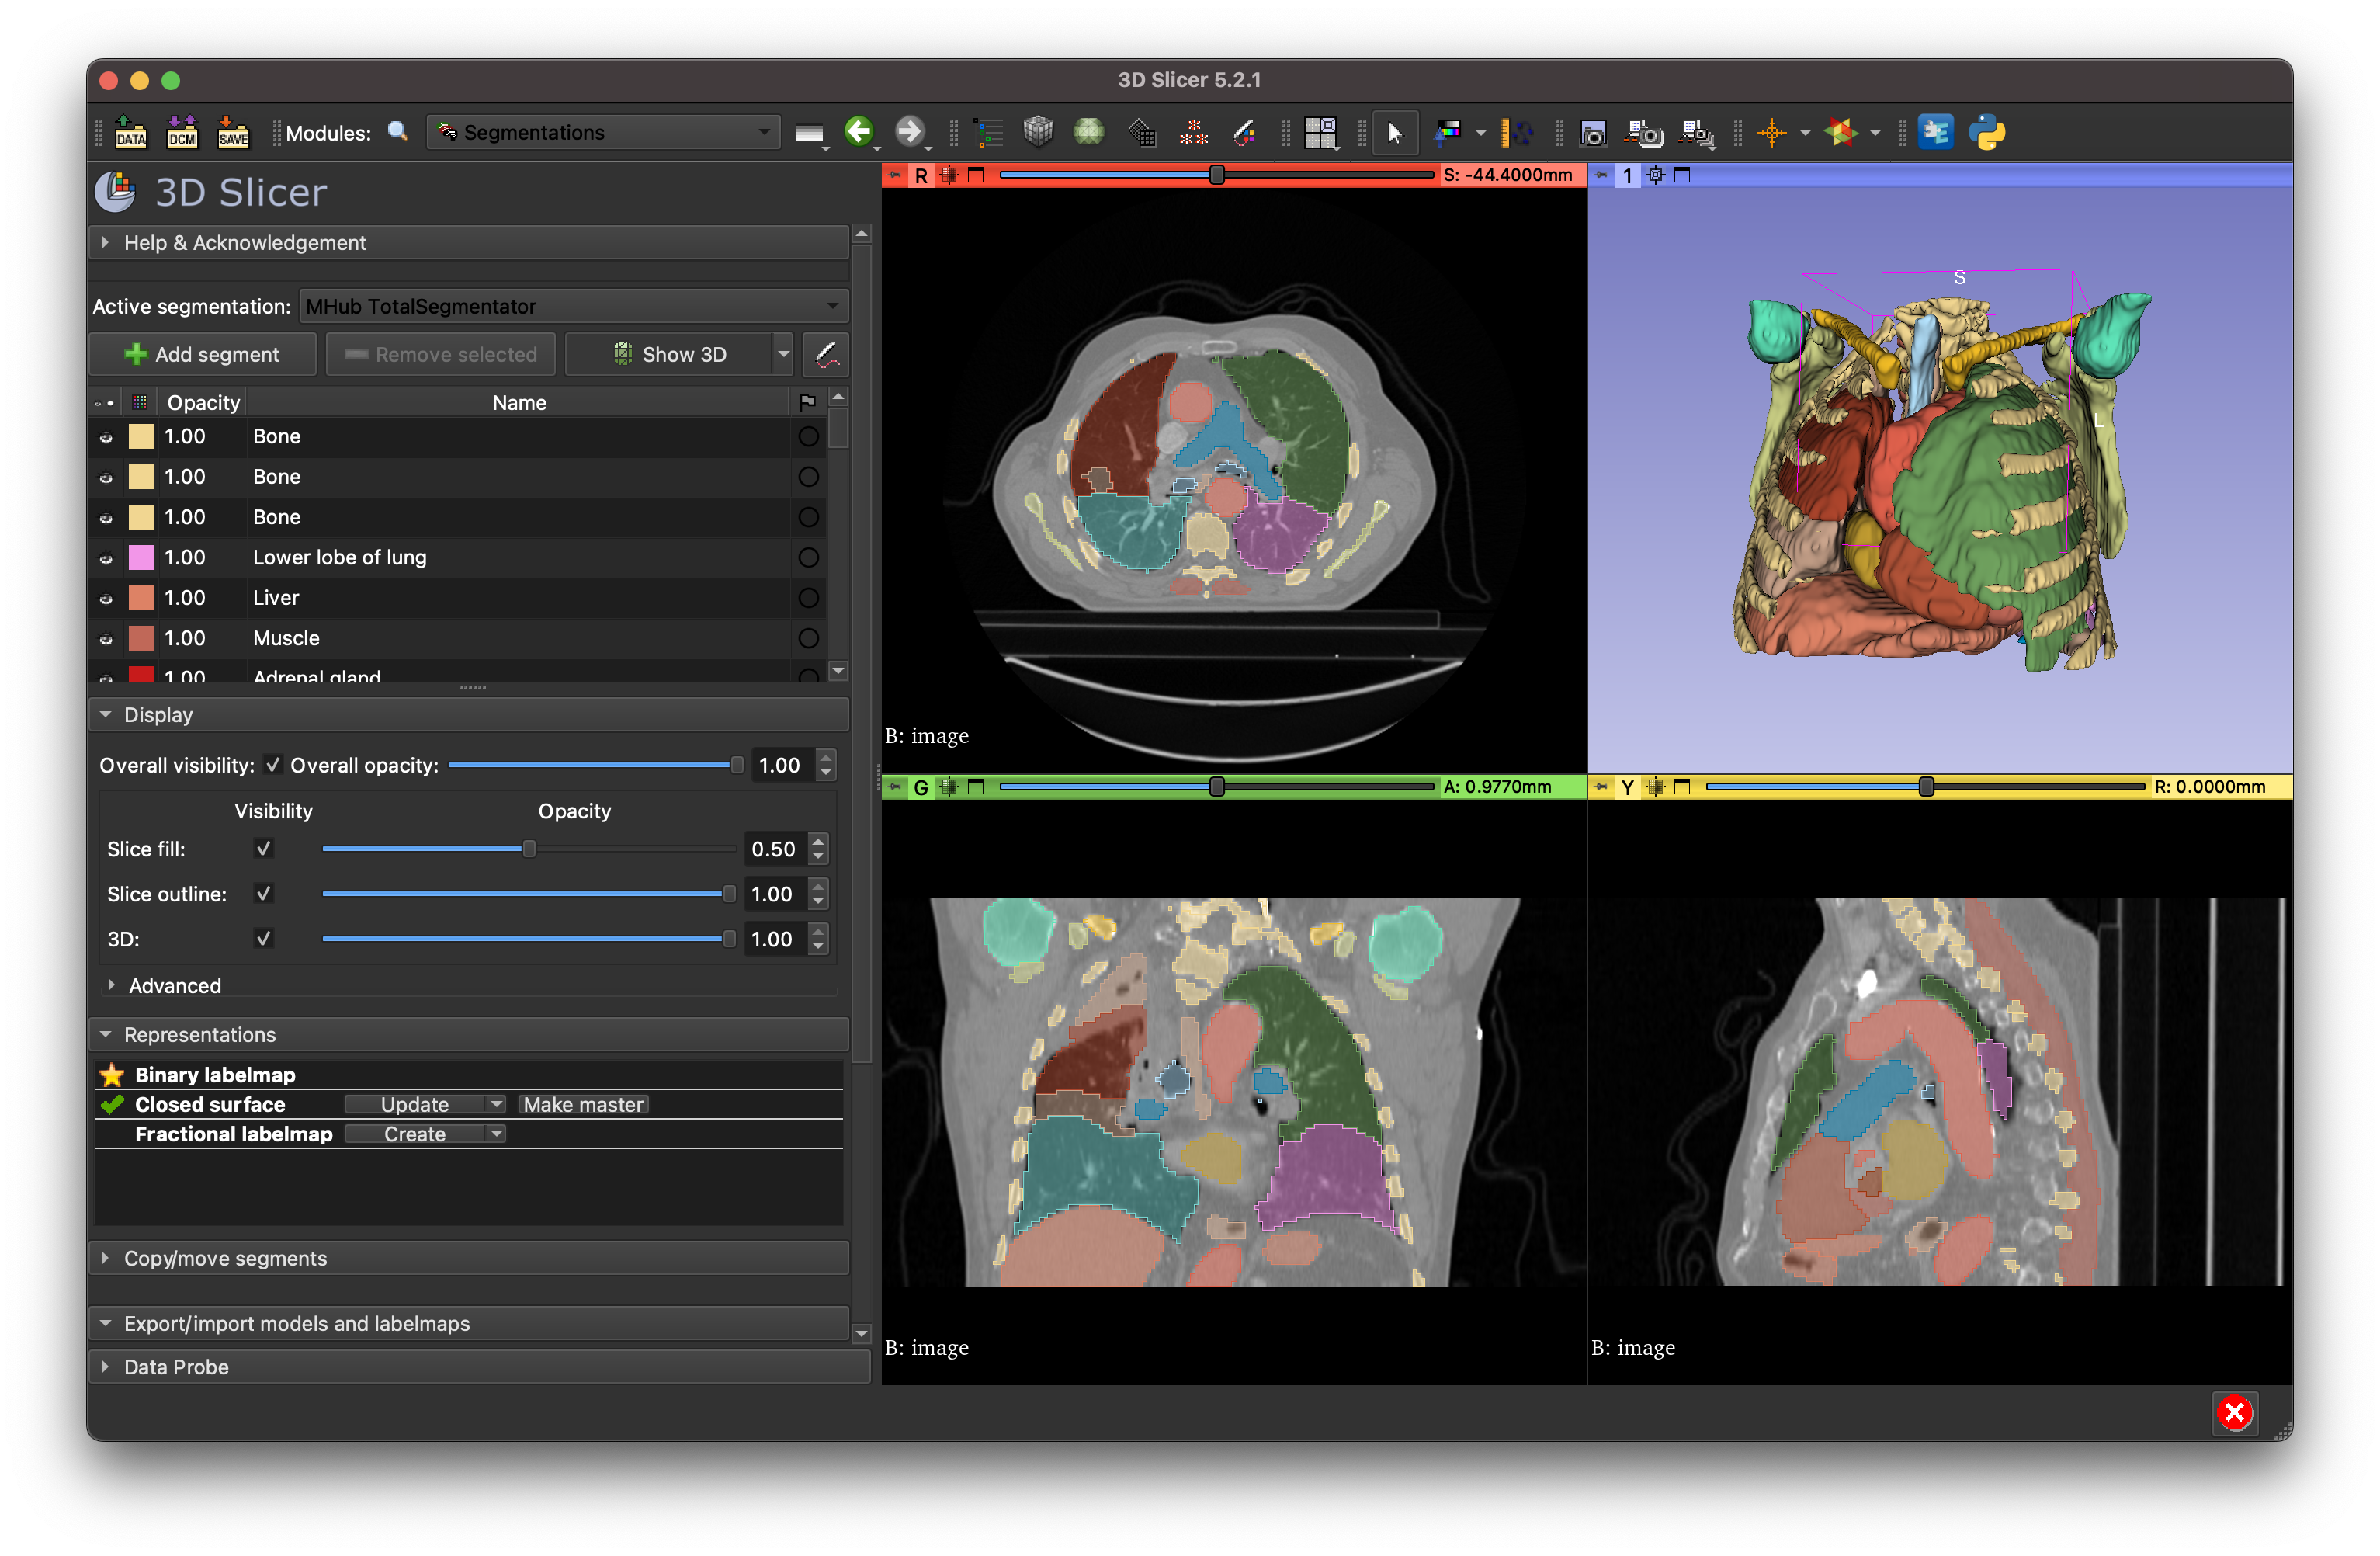